In [1]:
import tensorflow as tf

from distill.common.hparams import TransformerHparam, LSTMHparam
import os

from distill.data_util.prep_algorithmic import AlgorithmicIdentityDecimal40, AlgorithmicIdentityBinary40, \
  AlgorithmicAdditionDecimal40, AlgorithmicMultiplicationDecimal40, AlgorithmicSortProblem, AlgorithmicReverseProblem
from distill.data_util.prep_arithmatic import Arithmatic, ArithmaticSameLength, ArithmaticSimple, ArithmaticSimpleCurriculumLength,\
ArithmaticSimpleSameLength10, ArithmaticSimpleSameLength10Depth6, ArithmaticSimpleSameLength10Depth2, ArithmaticSimpleSameLength10Depth4
from distill.data_util.prep_imdb import IMDB
from distill.data_util.prep_ptb import PTB
from distill.data_util.prep_sst import SST
from distill.data_util.prep_trec6 import CharTrec6, Trec6
from distill.data_util.prep_wsj_parsing import ParseWSJ
from distill.models.lstm_seq2seq import LSTMSeq2Seq, BidiLSTMSeq2Seq
from distill.models.transformer import Transformer, UniversalTransformer, EncodingTransformer, \
  EncodingUniversalTransformer
from distill.pipelines.distill_pipelines import Seq2SeqDistiller
from distill.pipelines.seq2seq import Seq2SeqTrainer


from sklearn.decomposition import PCA
import pandas as pd
from sklearn import manifold
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline  

def plot_embeddings(M_reduced, word2Ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        Include a label next to each point.
    """
    for word in words:
        x, y = M_reduced[word2Ind[word]]
        plt.scatter(x, y, marker='x', color='red')
        plt.text(x+.01, y+.01, word, fontsize=10)
    plt.show()

    

# Enable TF Eager execution
tfe = tf.contrib.eager
tfe.enable_eager_execution()

# Other setup
Modes = tf.estimator.ModeKeys

In [2]:
tf.app.flags.DEFINE_string("exp_name", "distill", "")
tf.app.flags.DEFINE_string("task_name", "identity_binary", "")
tf.app.flags.DEFINE_string("log_dir", "logs", "")
tf.app.flags.DEFINE_string("data_dir", "data", "")

tf.app.flags.DEFINE_string("save_dir", None, "")

tf.app.flags.DEFINE_string("model_type", "lstm2transformer", "")
tf.app.flags.DEFINE_string("teacher_model", "lstm", "")
tf.app.flags.DEFINE_string("student_model", "enc_utransformer", "")

tf.app.flags.DEFINE_boolean("train_teacher", True, "")
tf.app.flags.DEFINE_boolean("train_student", True, "")
tf.app.flags.DEFINE_boolean("distill_rep", False, "")
tf.app.flags.DEFINE_boolean("distill_logit", True, "")

tf.app.flags.DEFINE_boolean("pretrain_teacher", True, "")
tf.app.flags.DEFINE_integer("teacher_pretraining_iters", 100, "")
tf.app.flags.DEFINE_string("rep_loss_mode", 'dot_product', "representation loss type (squared,softmax_cross_ent,sigmoid_cross_ent")

tf.app.flags.DEFINE_string("model", "enc_utransformer", "transformer | utransformer | lstm | bilstm")
tf.app.flags.DEFINE_string("teacher_encoder_attention_dir", "top_down", "top_down | bottom_up")
tf.app.flags.DEFINE_string("student_encoder_attention_dir", "top_down", "top_down | bottom_up")


tf.app.flags.DEFINE_integer("teacher_hidden_dim", 256, "")
tf.app.flags.DEFINE_integer("teacher_encoder_depth", 1, "")
tf.app.flags.DEFINE_integer("teacher_decoder_depth", 1, "")
tf.app.flags.DEFINE_integer("student_hidden_dim", 128, "")
tf.app.flags.DEFINE_integer("student_encoder_depth", 4, "")
tf.app.flags.DEFINE_integer("student_decoder_depth", 1, "")

tf.app.flags.DEFINE_integer("input_dim", None, "")
tf.app.flags.DEFINE_integer("output_dim", 1, "")
tf.app.flags.DEFINE_integer("number_of_heads", 4, "")
tf.app.flags.DEFINE_integer("ff_filter_size", 512, "")
tf.app.flags.DEFINE_float("initializer_gain", 1.0, "")
tf.app.flags.DEFINE_float("teacher_label_smoothing", 0.0001, "")
tf.app.flags.DEFINE_float("student_label_smoothing", 0.0001, "")

tf.app.flags.DEFINE_boolean('teacher_train_embeddings', True, " False | True")
tf.app.flags.DEFINE_boolean('student_train_embeddings', True, " False | True")

tf.app.flags.DEFINE_string('teacher_sent_rep_mode', "all", "none | final | all")
tf.app.flags.DEFINE_string('student_sent_rep_mode', "all", "none | final | all")

tf.app.flags.DEFINE_string('teacher_attention_mechanism', None, 'attention_mechanism')
tf.app.flags.DEFINE_string('student_attention_mechanism', None, 'attention_mechanism')


tf.app.flags.DEFINE_float("teacher_input_dropout_keep_prob", 0.8, "")
tf.app.flags.DEFINE_float("teacher_hidden_dropout_keep_prob", 0.9, "")
tf.app.flags.DEFINE_float("student_input_dropout_keep_prob", 0.75, "")
tf.app.flags.DEFINE_float("student_hidden_dropout_keep_prob", 0.5, "")


tf.app.flags.DEFINE_float("teacher_learning_rate", 0.001, "")
tf.app.flags.DEFINE_float("student_learning_rate", 0.001, "")
tf.app.flags.DEFINE_float("distill_learning_rate", 0.001, "")
tf.app.flags.DEFINE_float("data_weight", 0.00, "")
tf.app.flags.DEFINE_float("distill_logits_weight", 1.00, "")

tf.app.flags.DEFINE_float("distill_temp", 1, "")
tf.app.flags.DEFINE_float("teacher_temp", 1, "")
tf.app.flags.DEFINE_float("student_temp", 1, "")
tf.app.flags.DEFINE_boolean("learn_to_teach", False, "")



tf.app.flags.DEFINE_boolean("decay_learning_rate", True, "True | False")
tf.app.flags.DEFINE_float("l2_rate", 0.0001, "")


tf.app.flags.DEFINE_integer("batch_size", 32, "")
tf.app.flags.DEFINE_integer("training_iterations", 300000, "")

tf.app.flags.DEFINE_integer("vocab_size", 3, "")
tf.app.flags.DEFINE_integer("embedding_dim", 128, "embeddings dim")

tf.app.flags.DEFINE_string("data_path", "../data", "data path")



tf.app.flags.DEFINE_string("f","","kernel")
hparams = tf.app.flags.FLAGS

In [3]:
Models = {"lstm": LSTMSeq2Seq,
        "bilstm": BidiLSTMSeq2Seq,
        "transformer": Transformer,
        "utransformer": UniversalTransformer,
        "enc_transformer": EncodingTransformer,
        "enc_utransformer": EncodingUniversalTransformer}


tasks = {'identity': AlgorithmicIdentityDecimal40(os.path.join(hparams.data_dir,'alg')),
       'identity_binary': AlgorithmicIdentityBinary40(os.path.join(hparams.data_dir,'alg')),
       'addition': AlgorithmicAdditionDecimal40(os.path.join(hparams.data_dir,'alg')),
       'multiplication': AlgorithmicMultiplicationDecimal40(os.path.join(hparams.data_dir,'alg')),
       'sort': AlgorithmicSortProblem(os.path.join(hparams.data_dir,'alg')),
       'reverse': AlgorithmicReverseProblem(os.path.join(hparams.data_dir,'alg')),
       'arithmatic': Arithmatic(os.path.join(hparams.data_dir,'arithmatic')),
       'arithmatic_simple': ArithmaticSimple(os.path.join(hparams.data_dir,'arithmatic_simple')),
       'arithmatic_samelength': ArithmaticSameLength(os.path.join(hparams.data_dir,'arithmatic_samelength')),
       'arithmatic_simple_curriculum_length': ArithmaticSimpleCurriculumLength(os.path.join(hparams.data_dir,'arithmatic_simple_curriculum_length')),
       'arithmatic_simple_samelength': ArithmaticSameLength(os.path.join(hparams.data_dir,'arithmatic_samelength')),
       'arithmatic_simple_samelength10': ArithmaticSimpleSameLength10(os.path.join(hparams.data_dir,'arithmatic_simple_samelength10')),
       'arithmatic_simple_samelength10_depth6': ArithmaticSimpleSameLength10Depth6(os.path.join(hparams.data_dir,'arithmatic_simple_samelength10_depth6')),
       'arithmatic_simple_samelength10_depth4': ArithmaticSimpleSameLength10Depth4(os.path.join(hparams.data_dir,'arithmatic_simple_samelength10_depth4')),
       'arithmatic_simple_samelength10_depth2': ArithmaticSimpleSameLength10Depth2(os.path.join(hparams.data_dir,'arithmatic_simple_samelength10_depth2')),
       }


In [4]:
hparams.task_name = 'arithmatic_simple_samelength10_depth2'
hparams.vocab_size = tasks[hparams.task_name].vocab_length
hparams.output_dim = len(tasks[hparams.task_name].target_vocab)

PARAM_TYPES = {"lstm": LSTMHparam,
        "bilstm": LSTMHparam,
        "transformer": TransformerHparam,
        "utransformer": TransformerHparam,
        "enc_transformer": TransformerHparam,
        "enc_utransformer": TransformerHparam}

teacher_params = PARAM_TYPES[hparams.teacher_model](input_dim=hparams.input_dim,
                                                  output_dim=hparams.output_dim,
                                                  hidden_dim=hparams.teacher_hidden_dim,
                                                  encoder_depth=hparams.teacher_encoder_depth,
                                                  decoder_depth=hparams.teacher_decoder_depth,
                                                  number_of_heads=2,
                                                  ff_filter_size=512,
                                                  initializer_gain=hparams.initializer_gain,
                                                  batch_size=hparams.batch_size,
                                                  input_dropout_keep_prob=hparams.teacher_input_dropout_keep_prob,
                                                  hidden_dropout_keep_prob=hparams.teacher_hidden_dropout_keep_prob,
                                                  vocab_size=hparams.vocab_size,
                                                  label_smoothing=hparams.teacher_label_smoothing,
                                                  encoder_self_attention_dir=hparams.teacher_encoder_attention_dir,
                                                  decoder_self_attention_dir="top_down",
                                                  decoder_cross_attention_dir="top_down",
                                                  train_embeddings=hparams.teacher_train_embeddings,
                                                  attention_mechanism=None,
                                                  sent_rep_mode=hparams.teacher_sent_rep_mode,
                                                  embedding_dim=hparams.teacher_hidden_dim,
                                                  learning_rate=hparams.teacher_learning_rate
                                                  )

student_params = PARAM_TYPES[hparams.student_model](input_dim=hparams.input_dim,
                                                  output_dim=hparams.output_dim,
                                                  hidden_dim=hparams.student_hidden_dim,
                                                  encoder_depth=hparams.student_encoder_depth,
                                                  decoder_depth=hparams.student_decoder_depth,
                                                  number_of_heads=2,
                                                  ff_filter_size=512,
                                                  initializer_gain=hparams.initializer_gain,
                                                  batch_size=hparams.batch_size,
                                                  input_dropout_keep_prob=hparams.student_input_dropout_keep_prob,
                                                  hidden_dropout_keep_prob=hparams.student_hidden_dropout_keep_prob,
                                                  vocab_size=hparams.vocab_size,
                                                  label_smoothing=hparams.student_label_smoothing,
                                                  encoder_self_attention_dir=hparams.student_encoder_attention_dir,
                                                  decoder_self_attention_dir="top_down",
                                                  decoder_cross_attention_dir="top_down",
                                                  train_embeddings=hparams.student_train_embeddings,
                                                  attention_mechanism=None,
                                                  sent_rep_mode=hparams.student_sent_rep_mode,
                                                  embedding_dim=hparams.student_hidden_dim,
                                                  learning_rate=hparams.student_learning_rate
                                                  )

In [5]:
print(hparams.student_model)
student_model = Models[hparams.student_model](student_params,
                                task=tasks[hparams.task_name],
                                scope=hparams.student_model+"_student")

lstm


In [6]:
print(hparams.teacher_model)
teacher_model = Models[hparams.teacher_model](teacher_params,
                                task=tasks[hparams.task_name],
                                scope=hparams.teacher_model+"_teacher")

lstm


In [7]:
dataset = tf.data.TFRecordDataset("../"+student_model.task.get_tfrecord_path(mode="train"))
dataset = dataset.map(student_model.task.parse_examples)
dataset = dataset.padded_batch(hparams.batch_size, padded_shapes=student_model.task.get_padded_shapes())
dataset = dataset.map((lambda x1,x2,x3,x4: ((x1,x2,x3,x4),(x1,x2,x3,x4))))
dataset = dataset.shuffle(buffer_size=1000)
dataset = dataset.repeat()
train_iterator = dataset.make_one_shot_iterator()

dataset = tf.data.TFRecordDataset("../"+student_model.task.get_tfrecord_path(mode="dev"))
dataset = dataset.map(student_model.task.parse_examples)
dataset = dataset.padded_batch(hparams.batch_size, padded_shapes=student_model.task.get_padded_shapes())
dataset = dataset.map((lambda x1,x2,x3,x4: ((x1,x2,x3,x4),(x1,x2,x3,x4))))
dataset = dataset.shuffle(buffer_size=1000)
dataset = dataset.repeat()
dev_iterator = dataset.make_one_shot_iterator()

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
teacher_train_examples, student_train_examples = train_iterator.get_next()
teacher_dev_examples, student_dev_examples = dev_iterator.get_next()

student_model.create_vars(reuse=False)



Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.


In [9]:
save_dir = '../logs/arithmatic_simple_samelength10_depth2/'+ \
'dot_product_lstm_to_lstm_std_depth1_teacher_depth1_std_hidden_dim128_teacher_hidden_dim128__indp_drop075-08_drop075-08_L2_v5'
checkpoint = tf.train.latest_checkpoint(save_dir)
print(checkpoint)

../logs/arithmatic_simple_samelength10_depth2/dot_product_lstm_to_lstm_std_depth1_teacher_depth1_std_hidden_dim128_teacher_hidden_dim128__indp_drop075-08_drop075-08_L2_v5/model.ckpt-600000


In [10]:
with tfe.restore_variables_on_create(checkpoint):
    teacher_model.create_vars(reuse=False)
    train_output_dic = teacher_model.apply(teacher_train_examples, target_length=student_model.task.target_length, is_train=False)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use tf.cast instead.


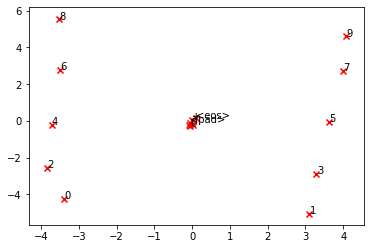

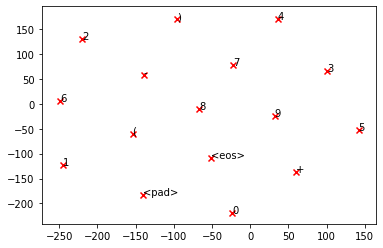

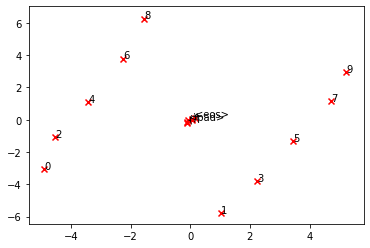

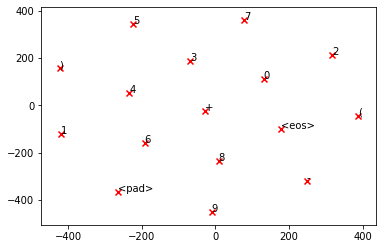

In [11]:
with tfe.restore_variables_on_create(checkpoint):
    teacher_model.create_vars(reuse=False)
    emb_w = teacher_model.input_embedding_layer.shared_weights



pca = PCA(n_components=2)
principalComponents = pca.fit_transform(emb_w.numpy())
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
tsne_emb = tsne.fit_transform(emb_w.numpy())

M_reduced_plot_test = principalComponents
word2Ind_plot_test = student_model.task.word2id
words = student_model.task.id2word
plot_embeddings(M_reduced_plot_test, word2Ind_plot_test, words)

M_reduced_plot_test = tsne_emb
word2Ind_plot_test = student_model.task.word2id
words = student_model.task.id2word
plot_embeddings(M_reduced_plot_test, word2Ind_plot_test, words)


with tfe.restore_variables_on_create(checkpoint):
    student_model.create_vars(reuse=False)
    emb_w = student_model.input_embedding_layer.shared_weights



pca = PCA(n_components=2)
principalComponents = pca.fit_transform(emb_w.numpy())
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
tsne_emb = tsne.fit_transform(emb_w.numpy())

M_reduced_plot_test = principalComponents
word2Ind_plot_test = student_model.task.word2id
words = student_model.task.id2word
plot_embeddings(M_reduced_plot_test, word2Ind_plot_test, words)

M_reduced_plot_test = tsne_emb
word2Ind_plot_test = student_model.task.word2id
words = student_model.task.id2word
plot_embeddings(M_reduced_plot_test, word2Ind_plot_test, words)


In [12]:
example_str = '1 + 2 - ( 2 + 1 ) + 3  + ( 2 + 1 ) - 3 <eos>'
example_input = example_str.split()
target = str(eval(example_str[0:-5]))
encoded_example = tf.convert_to_tensor([teacher_model.task.encode(example_input)])
encoded_target = tf.convert_to_tensor([teacher_model.task.encode(target)])

print(example_input)
example = (encoded_example, encoded_target, tf.convert_to_tensor([len(example_input)]), tf.convert_to_tensor([1]))

weights_dic = {}
with tfe.restore_variables_on_create(checkpoint):
    teach_outputs = train_output_dic = teacher_model.apply(example, \
                                                     target_length=teacher_model.task.target_length, is_train=False)

print(' '.join(student_model.task.decode(example[0][0])))
print(student_model.task.decode([np.argmax(teach_outputs['logits'][0][0])]))

['1', '+', '2', '-', '(', '2', '+', '1', ')', '+', '3', '+', '(', '2', '+', '1', ')', '-', '3', '<eos>']
1 + 2 - ( 2 + 1 ) + 3 + ( 2 + 1 ) - 3 <eos>
['3']


In [13]:
teacher_train_examples, student_train_examples = train_iterator.get_next()
teacher_dev_examples, student_dev_examples = dev_iterator.get_next()

with tfe.restore_variables_on_create(checkpoint):
    train_output_dic = teacher_model.apply(teacher_train_examples, target_length=teacher_model.task.target_length, is_train=False)

In [14]:
np.argmax(train_output_dic['logits'], axis=-1) == train_output_dic['targets'].numpy()

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True]])

In [15]:
np.argmax(train_output_dic['logits'], axis=-1)

array([[ 7],
       [ 7],
       [ 9],
       [ 9],
       [ 6],
       [11],
       [ 2],
       [ 6],
       [11],
       [11],
       [ 6],
       [11],
       [ 8],
       [ 9],
       [ 6],
       [ 3],
       [ 7],
       [11],
       [ 4],
       [10],
       [ 8],
       [11],
       [ 5],
       [ 8],
       [ 4],
       [ 4],
       [ 7],
       [ 9],
       [10],
       [ 4],
       [ 2],
       [ 7]])

(32, 16)


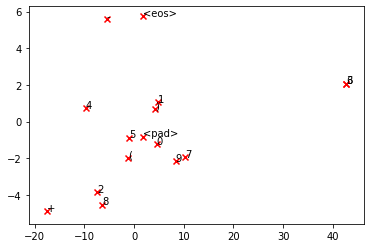

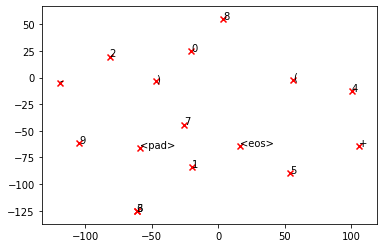

In [16]:
print(train_output_dic['logits'].numpy()[:,0,:].shape)

points = train_output_dic['logits'].numpy()[:,0,:]
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(points)

tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
tsne_emb = tsne.fit_transform(points)

M_reduced_plot_test = principalComponents
word2Ind_plot_test = student_model.task.word2id
words = student_model.task.id2word
plot_embeddings(M_reduced_plot_test, word2Ind_plot_test, words)

M_reduced_plot_test = tsne_emb
word2Ind_plot_test = student_model.task.word2id
words = student_model.task.id2word
plot_embeddings(M_reduced_plot_test, word2Ind_plot_test, words)

In [17]:
examples_inputs = []
examples_targets = []
target_lens = []
input_lens = []
for i in student_model.task.id2word:
    example_str = i+' <eos>'
    example_input = example_str.split()
    examples_inputs.append(teacher_model.task.encode(example_input))
    try:
        target = str(eval(example_str[0:-5]))
        examples_targets.append(teacher_model.task.encode(target))
    except:
        target = 0
    target_lens.append(1)
    input_lens.append(len(example_input))
    
    
encoded_example = tf.convert_to_tensor(examples_inputs)
encoded_target = tf.convert_to_tensor(examples_targets)

example = (encoded_example, encoded_target, tf.convert_to_tensor(input_lens), tf.convert_to_tensor(target_lens))

weights_dic = {}
with tfe.restore_variables_on_create(checkpoint):
    teach_outputs = teacher_model.apply(example, target_length=teacher_model.task.target_length, is_train=False)
    student_outputs = student_model.apply(example, target_length=student_model.task.target_length, is_train=False)

In [18]:
list(zip(np.argmax(teach_outputs['logits'], axis=-1), np.argmax(student_outputs['logits'], axis=-1), teach_outputs['targets'].numpy()))

[(array([6]), array([4]), array([2], dtype=int32)),
 (array([6]), array([4]), array([3], dtype=int32)),
 (array([4]), array([3]), array([4], dtype=int32)),
 (array([3]), array([3]), array([5], dtype=int32)),
 (array([4]), array([4]), array([6], dtype=int32)),
 (array([5]), array([5]), array([7], dtype=int32)),
 (array([6]), array([6]), array([8], dtype=int32)),
 (array([7]), array([7]), array([9], dtype=int32)),
 (array([8]), array([8]), array([10], dtype=int32)),
 (array([9]), array([9]), array([11], dtype=int32))]

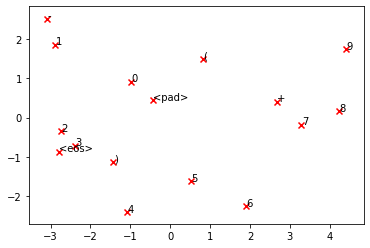

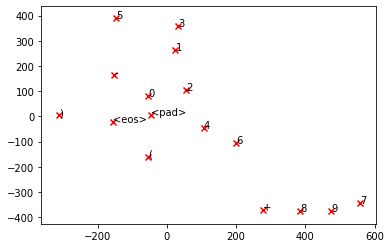

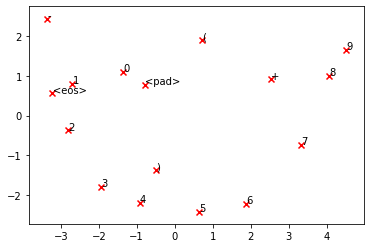

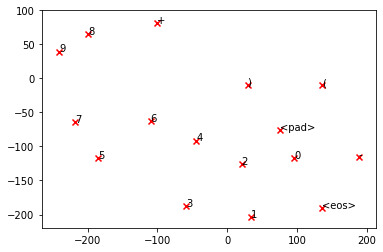

In [19]:
reps = teach_outputs['outputs'].numpy()[:,0,:]


points = reps
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(points)

tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=3)
tsne_emb = tsne.fit_transform(points)

M_reduced_plot_test = principalComponents
word2Ind_plot_test = student_model.task.word2id
words = student_model.task.id2word
plot_embeddings(M_reduced_plot_test, word2Ind_plot_test, words)

M_reduced_plot_test = tsne_emb
word2Ind_plot_test = student_model.task.word2id
words = student_model.task.id2word
plot_embeddings(M_reduced_plot_test, word2Ind_plot_test, words)



reps = student_outputs['outputs'].numpy()[:,0,:]


points = reps
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(points)

tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=4)
tsne_emb = tsne.fit_transform(points)

M_reduced_plot_test = principalComponents
word2Ind_plot_test = student_model.task.word2id
words = student_model.task.id2word
plot_embeddings(M_reduced_plot_test, word2Ind_plot_test, words)

M_reduced_plot_test = tsne_emb
word2Ind_plot_test = student_model.task.word2id
words = student_model.task.id2word
plot_embeddings(M_reduced_plot_test, word2Ind_plot_test, words)